In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import glob

In [2]:
train_images = np.zeros(1000*256*512*3, dtype=np.float32).reshape(1000, 256, 512, 3)
valid_images = np.zeros(5*256*512*3, dtype=np.float32).reshape(5, 256, 512, 3)

for i, filename in enumerate(glob.glob("./cityscapes/train/*jpg")):
    image = np.array(Image.open(filename), dtype=np.float32)
    train_images[i, :, :, :] = image

for i, filename in enumerate(glob.glob("./cityscapes/val/*jpg")):
    image = np.array(Image.open(filename), dtype=np.float32)
    valid_images[i, :, :, :] = image

(256, 512, 3)
(256, 512, 3)


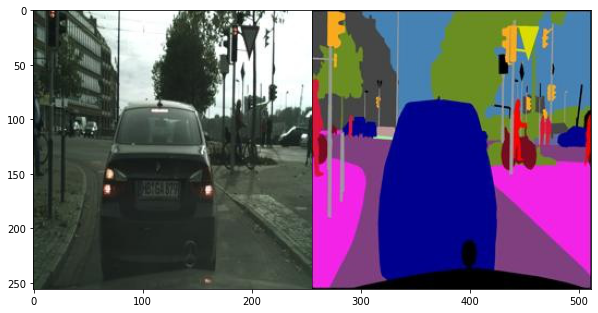

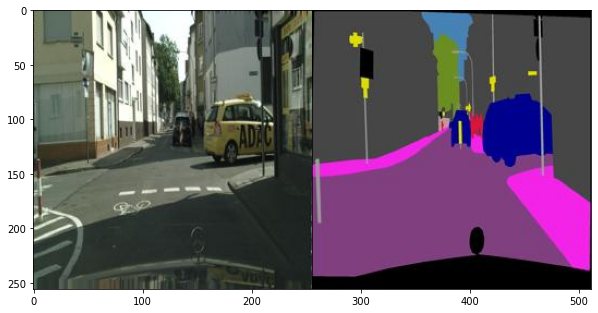

In [3]:
print(train_images[0].shape)
plt.figure(figsize=(10, 10))
plt.imshow(train_images[0].astype(int))

print(valid_images[2].shape)
plt.figure(figsize=(10, 10))
plt.imshow(valid_images[2].astype(int))

In [4]:
middle = 256
real_images = train_images[:, :, :middle, :]
segments = train_images[:, :, middle:, :]

valid_segments = valid_images[:, :, middle:, :]
valid_images = valid_images[:, :, :middle, :]

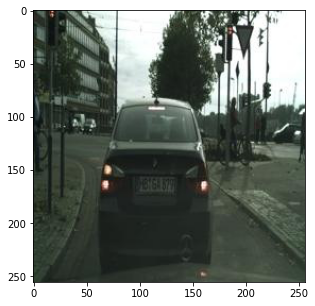

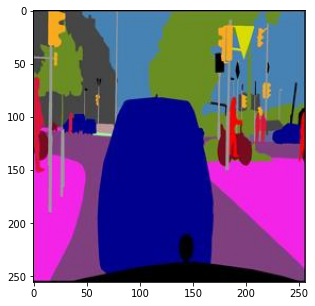

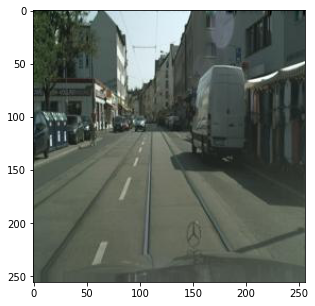

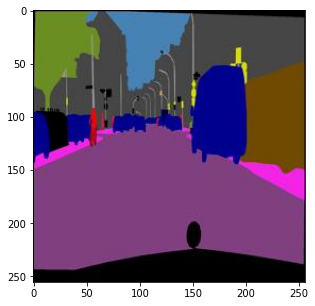

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(real_images[0].astype(int))
plt.figure(figsize=(5, 5))
plt.imshow(segments[0].astype(int))

plt.figure(figsize=(5, 5))
plt.imshow(valid_images[0].astype(int))
plt.figure(figsize=(5, 5))
plt.imshow(valid_segments[0].astype(int))

In [6]:
batch_size = 32
buffer_size = 1000

segments = (segments / 127.5) - 1
real_images = (real_images / 127.5) - 1

valid_segments = (valid_segments / 127.5) - 1
valid_images = (valid_images / 127.5) - 1

train_images = tf.data.Dataset.from_tensor_slices((segments, real_images)).shuffle(buffer_size).batch(batch_size)

In [7]:
class EncodeBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = tf.keras.layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.lrelu= tf.keras.layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [8]:
class UNetGenerator(tf.keras.Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        #augmentation
        self.flip = tf.keras.layers.RandomFlip("horizontal")
        self.rotate = tf.keras.layers.RandomRotation(0.2)
        self.zoom = tf.keras.layers.RandomZoom(0.2)
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = tf.keras.layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        x = self.flip(x)
        x = self.rotate(x)
        x = self.zoom(x)
        
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = tf.keras.layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = tf.keras.Input(input_shape)
        return tf.keras.Model(inputs, self.call(inputs)).summary()

In [9]:
class DecodeBlock(tf.keras.layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = tf.keras.layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = tf.keras.layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class DiscBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = tf.keras.layers.ZeroPadding2D()
            self.conv = tf.keras.layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = tf.keras.layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = tf.keras.layers.BatchNormalization() if use_bn else None
        self.lrelu = tf.keras.layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [11]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = tf.keras.layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = tf.keras.layers.Activation("sigmoid")
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = tf.keras.Input(x_shape), tf.keras.Input(y_shape) 
        return tf.keras.Model((x, y), self.call(x, y)).summary()

In [12]:
Discriminator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate[0][0]            

In [13]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mae = tf.keras.losses.MeanAbsoluteError()

gene_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [14]:
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_colored = generator(sketch, training=True)
        
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [15]:
generator = UNetGenerator()
discriminator = Discriminator()

In [16]:
def generate_images(model, valid_segments):
    predictions = model(valid_segments, training=False)
    pred_image = predictions.numpy()
    pred_image = (pred_image*127.5)+127.5
    pred_image = pred_image.astype(int)
    
    fig = plt.figure(figsize=(20, 20))
    for i in range(pred_image.shape[0]):
        plt.subplot(1, 5, i+1)
        plt.imshow(pred_image[i, :, :, :])
        plt.axis("off")
   
    plt.show()
    
    return pred_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


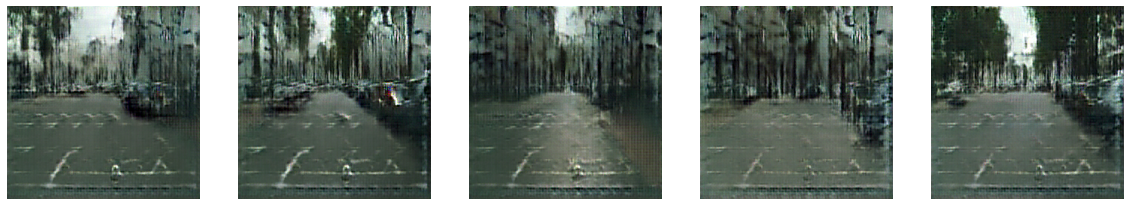

epoch : 500, real_loss : 4.17608118057251, fake_loss : 0.05640951544046402


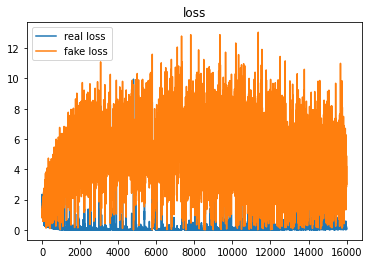

In [17]:
EPOCHS = 500
real_loss = []
fake_loss = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        real_loss.append(d_loss)
        fake_loss.append(g_loss)
    
    display.clear_output(wait=True)
    generate_images(generator, valid_segments)
    print("epoch : {}, real_loss : {}, fake_loss : {}".format(epoch, g_loss, d_loss))  
plt.plot(real_loss, label="real loss")
plt.plot(fake_loss, label="fake loss")
plt.title("loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


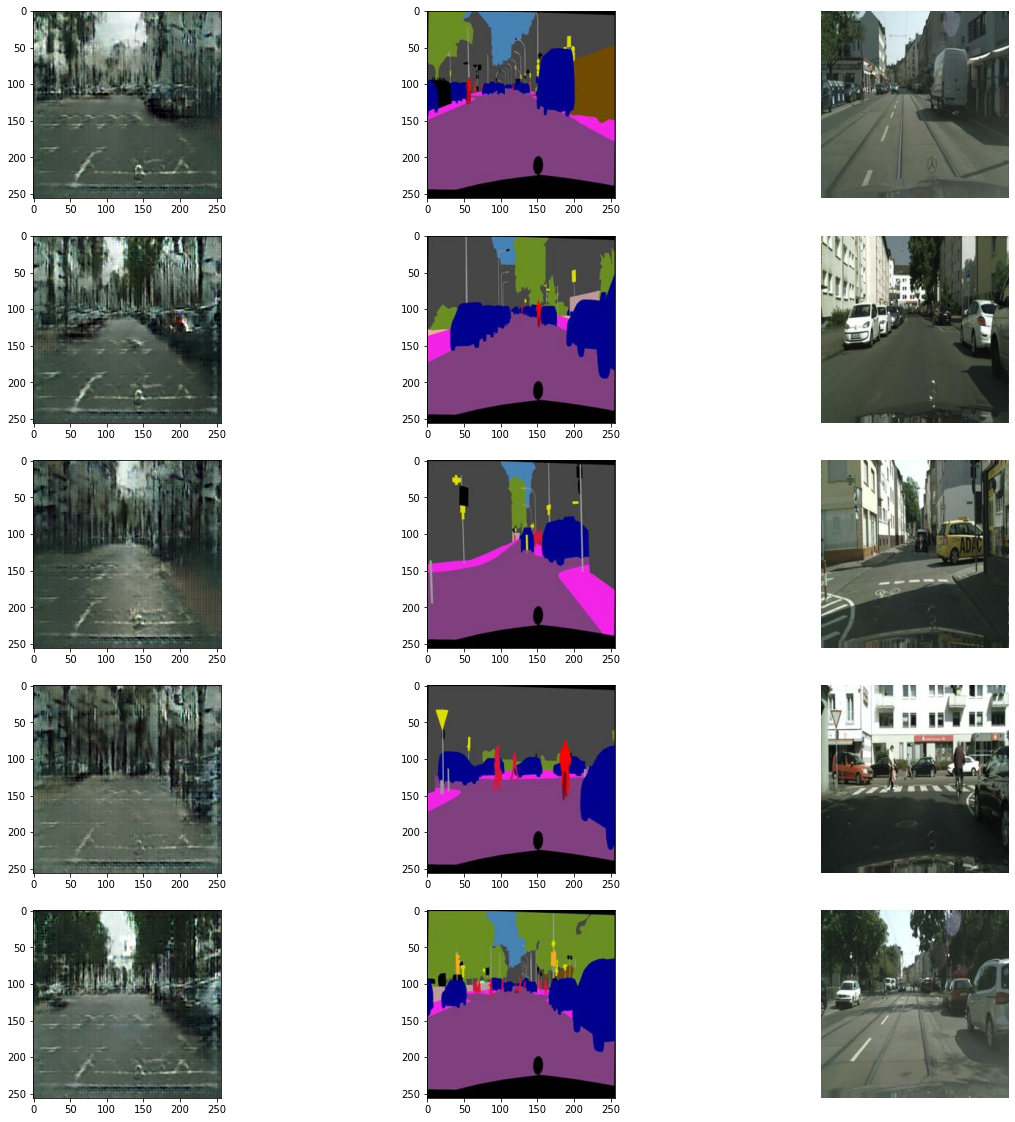

In [26]:
predictions = generator(valid_segments, training=False)
pred_image = predictions.numpy()
pred_image = (pred_image*127.5)+127.5
pred_image = pred_image.astype(int)

valid_segments = (valid_segments*127.5)+127.5
valid_segments = valid_segments.astype(int)

valid_images = (valid_images*127.5)+127.5
valid_images = valid_images.astype(int)

fig = plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(pred_image[i, :, :, :])
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(valid_segments[i, :, :, :])
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(valid_images[i, :, :, :])
    plt.axis("off")
   
plt.show()
    

## 결론
### unet으로 pix2pix구현하고 7시간동안 500에폭 돌려봤습니다ㅋㅋㅋㅋ 이게 뭔짓인지..싶은 플젝이였네요 결론부터 말하면 결과가 깔끔하지는 않았습니다. 아무래도 들어오는 segment 사이즈에 맞춰서 피쳐사이즈 조정해줘야되는데 그부분이 부족하지 않았나 생각됩니다.
### 생성모델 트랜드가 아무래도 pixel단위에서 어느정도 정교한 표현을 보여주는냐가 포인트이기 때문에 모델링보다는 성능향상에 집중되는 느낌?? 나중에 프로젝트 생성모델을 하게 될지 안하게 될진 모르겠지만 하게된다면 성능향상쪽으로 페이퍼서치를 꼼꼼히 해야될듯 하네요